In [2]:
# Dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report


os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow import keras
from tensorflow.keras.preprocessing import image

from PIL import Image

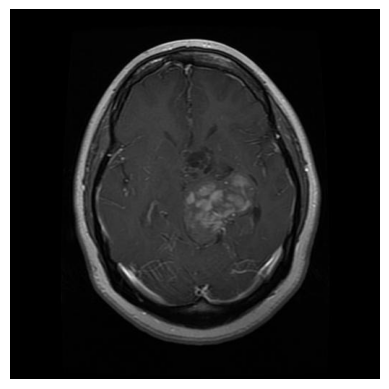

In [3]:
image_path = '../MRI_DATA/Training/tumor/gg 1(1).jpg'

img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# Balance the Data Sets

In [4]:
# Image Augmentation to balance the data sets

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os

# Define the directory for 'no_tumor' images and where to save augmented images
no_tumor_dir = '../MRI_DATA/Training/no_tumor'
save_dir = '../MRI_DATA/Training/no_tumor'

# Initialize the ImageDataGenerator with your chosen augmentations
augmentation = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
# Determine the number of augmented images
augmentations_per_image = 6  # 6 * 395 = 2370 augmented images

# List all 'no_tumor' images
no_tumor_images = os.listdir(no_tumor_dir)

# Process and augment each 'no_tumor' image
for img_name in no_tumor_images:
    # Load the image
    img_path = os.path.join(no_tumor_dir, img_name)
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)  # Reshape
    
    # Initialize a counter for this image
    i = 0
    # Generate augmented images
    for batch in augmentation.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix='no_tumor', save_format='jpg'):
        i += 1
        if i >= augmentations_per_image:
            break  # Stop the loop once we hit the target


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_width, image_height = 224, 224

# Create an ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    horizontal_flip=True,  # Randomly flip inputs horizontally
    validation_split=0.2)  # validation split

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '../MRI_DATA/Training/',
        target_size=(image_width, image_height),
        batch_size=32,
        class_mode='binary',
        subset='training')  # Set as training data

# Flow validation images in batches using train_datagen generator
validation_generator = train_datagen.flow_from_directory(
        '../MRI_DATA/Training/',
        target_size=(image_width, image_height),
        batch_size=32,
        class_mode='binary',
        subset='validation')

Found 10296 images belonging to 2 classes.
Found 2574 images belonging to 2 classes.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    MaxPooling2D(2, 2),
    
    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Convolutional layer 4
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flattening the 3D output to 1D
    Flatten(),
    
    # Dropout to reduce overfitting
    Dropout(0.5),
    
    # Dense layer for prediction
    Dense(512, activation='relu'),
    
    # Output layer 
    Dense(1, activation='sigmoid')
])

# Printing the model summary to review the architecture
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)      

In [8]:
# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
# training the model

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs = 10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/10


321/321 [==============================] - 240s 743ms/step - loss: 0.1937 - accuracy: 0.9318 - val_loss: 0.3569 - val_accuracy: 0.9137
Epoch 2/10
321/321 [==============================] - 211s 657ms/step - loss: 0.0633 - accuracy: 0.9827 - val_loss: 0.2633 - val_accuracy: 0.9246
Epoch 3/10
321/321 [==============================] - 242s 755ms/step - loss: 0.0439 - accuracy: 0.9878 - val_loss: 0.2797 - val_accuracy: 0.9250
Epoch 4/10
321/321 [==============================] - 228s 710ms/step - loss: 0.0404 - accuracy: 0.9886 - val_loss: 0.2494 - val_accuracy: 0.9266
Epoch 5/10
321/321 [==============================] - 221s 688ms/step - loss: 0.0312 - accuracy: 0.9900 - val_loss: 0.4159 - val_accuracy: 0.9008
Epoch 6/10
321/321 [==============================] - 220s 685ms/step - loss: 0.0209 - accuracy: 0.9936 - val_loss: 0.5589 - val_accuracy: 0.8863
Epoch 7/10
321/321 [==============================] - 228s 709ms/step - loss: 0.0192 - accuracy: 0.9944 - val_loss: 0.2992

In [10]:
# Retrieve the training history
training_history = history.history

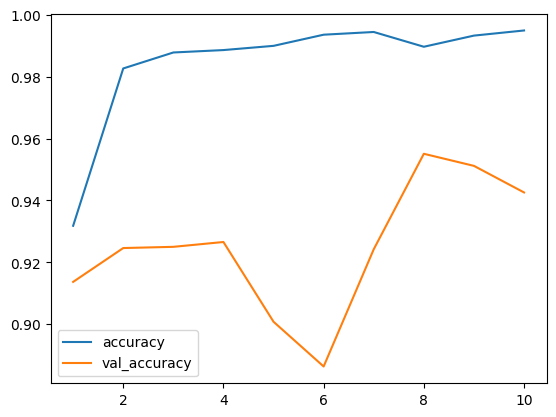

In [11]:
# Create a DataFrame containing training history
import pandas as pd
history_df = pd.DataFrame(history.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1
# Plot the accuracy
history_df.plot(y=["accuracy", "val_accuracy"])
plt.show()

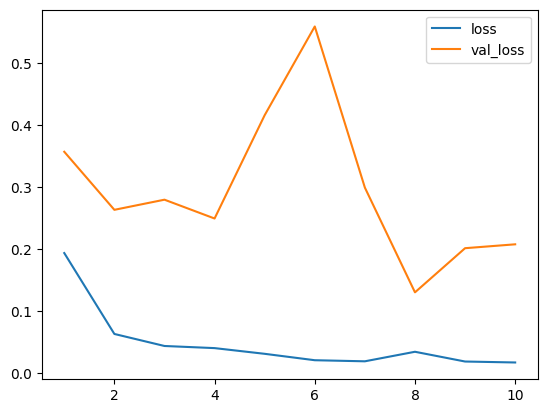

In [12]:
# Plot the loss
history_df.plot(y=["loss","val_loss"])
plt.show()

In [13]:
# rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# create the test_generator
test_generator = test_datagen.flow_from_directory(
    '../MRI_DATA/Testing/',
    target_size=(image_width, image_height),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

# evaluate the model on the testing set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f'Test accuracy: {test_acc*100:.2f}%')


Found 394 images belonging to 2 classes.
6/6 [==============================] - 2s 358ms/step - loss: 0.7673 - accuracy: 0.7995
Test accuracy: 79.95%


# Actual test

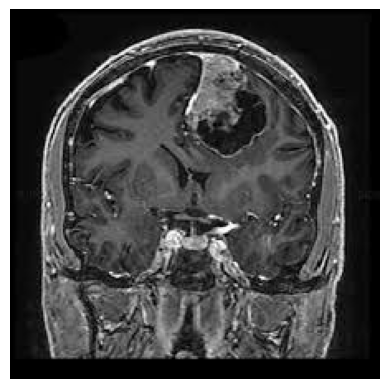

In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Path to specific image
image_path = '../MRI_DATA/Testing/tumor/image2(69).jpg'

# Load the image and resize it to match the input shape
img = image.load_img(image_path, target_size=(image_width, image_height))

# Display the loaded image
plt.imshow(img)
plt.axis('off')  # Remove axes for clarity
plt.show()

# Convert the image to a numpy array and rescale
img_array = image.img_to_array(img) / 255.

# Add an extra dimension for the batch size
img_array = np.expand_dims(img_array, axis=0)

In [15]:
# Make predictions
predictions = model.predict(img_array)

# Display the raw prediction value
print(f"Raw prediction score: {predictions[0]}")

# Interpret the prediction score as class labels
predicted_class = 'tumor' if predictions[0] > 0.5 else 'no_tumor'
print(f"Predicted class name: {predicted_class}")

1/1 [==============================] - 0s 267ms/step
Raw prediction score: [0.9999968]
Predicted class name: tumor


## Model Results

In [16]:

# Directory containing the images
main_directory = '../MRI_DATA/Testing/'

# Lists to store image paths, actual results, and predictions
image_paths = []
actual_results = []
predicted_results = []

# Iterate through the files in the directory
for root, dirs, files in os.walk(main_directory):
    for file in files:
        # Check if the file is a JPG image
        if file.endswith('.jpg'):
            # Construct the full path to the image
            image_path = os.path.join(root, file)
            
            # Extract the actual result from the image path
            actual_result = 'no_tumor' if 'no_tumor' in image_path else 'tumor'
            
            # Load the image
            img = image.load_img(image_path, target_size=(image_width, image_height))
            img_array = image.img_to_array(img)
            img_array = img_array / 255.0  # Normalize the pixel values
            
            # Make predictions
            predictions = model.predict(img_array.reshape(1, image_width, image_height, 3))
            
            # Interpret the prediction score as class labels
            predicted_result = 'tumor' if predictions[0] > 0.5 else 'no_tumor'
            
            # Append image path, actual result, and prediction to the lists
            image_paths.append(image_path)
            actual_results.append(actual_result)
            predicted_results.append(predicted_result)


1/1 [==============================] - 0s 23ms/step


In [17]:
# Create DataFrame with image paths, actual results, and predictions
df = pd.DataFrame({'Image_Path': image_paths, 'Actual_Result': actual_results, 'Predicted_Result': predicted_results})

# # Set display options to show all rows
# pd.set_option('display.max_rows', None)

df.head(5)

,Image_Path,Actual_Result,Predicted_Result
0,../MRI_DATA/Testing/no_tumor\image(1).jpg,no_tumor,no_tumor
1,../MRI_DATA/Testing/no_tumor\image(10).jpg,no_tumor,no_tumor
2,../MRI_DATA/Testing/no_tumor\image(100).jpg,no_tumor,no_tumor
3,../MRI_DATA/Testing/no_tumor\image(101).jpg,no_tumor,tumor
4,../MRI_DATA/Testing/no_tumor\image(102).jpg,no_tumor,no_tumor


In [18]:
# Generate confusion matrix and classification report
y_target = df['Actual_Result']
prediction = df['Predicted_Result']
conf_matrix = confusion_matrix(y_target, prediction)
class_report = classification_report(y_target, prediction)


In [19]:
# Display confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[ 70  35]
 [ 46 243]]

Classification Report:
              precision    recall  f1-score   support

    no_tumor       0.60      0.67      0.63       105
       tumor       0.87      0.84      0.86       289

    accuracy                           0.79       394
   macro avg       0.74      0.75      0.75       394
weighted avg       0.80      0.79      0.80       394



In [20]:
model.save('../Models/TZ_14_89.keras')